In [63]:
! conda install geopandas -qy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import zipfile
import requests
import os
import shutil

%matplotlib inline

from downloading_funcs import addr_shape, down_extract_zip
from supp_funcs import zoneConcentration, pointInZone
import lnks



# All requested packages already installed.
# packages in environment at /opt/conda:
#
geopandas                 0.3.0                    py36_0    conda-forge


In [64]:
#Load the BBL list
BBL12_17CSV = ['https://opendata.arcgis.com/datasets/82ab09c9541b4eb8ba4b537e131998ce_22.csv', 'https://opendata.arcgis.com/datasets/4c4d6b4defdf4561b737a594b6f2b0dd_23.csv',   'https://opendata.arcgis.com/datasets/d7aa6d3a3fdc42c4b354b9e90da443b7_1.csv',     'https://opendata.arcgis.com/datasets/a8434614d90e416b80fbdfe2cb2901d8_2.csv', 'https://opendata.arcgis.com/datasets/714d5f8b06914b8596b34b181439e702_36.csv',     'https://opendata.arcgis.com/datasets/c4368a66ce65455595a211d530facc54_3.csv',]

In [65]:
def data_pipeline(shapetype, bbl_links, supplement=None,
                 dex=None, ts_lst_range=None):
    #A pipeline for group_e dataframe operations
    
    
    #Test inputs --------------------------------------------------------------
    if supplement:
        assert isinstance(supplement, list)
    assert isinstance(bbl_links, list)
    if ts_lst_range:
        assert isinstance(ts_lst_range, list)
        assert len(ts_lst_range) == 2 #Must be list of format [start-yr, end-yr]
    
    #We'll need our addresspoints and our shapefile
    if not dex:
        dex = addr_shape(shapetype)
    
    #We need a list of time_unit_of_analysis
    if ts_lst_range:
        ts_lst = [x+(i/100) for i in range(1,13,1) for x in range(1980, 2025)]
        ts_lst = [x for x in ts_lst if 
                  x >= ts_lst_range[0] and x <= ts_lst_range[1]]
        ts_lst = sorted(ts_lst)
    if not ts_lst_range:
        ts_lst = [x+(i/100) for i in range(1,13,1) for x in range(2012, 2017)]
        ts_lst = sorted(ts_lst)
    
    #Now we need to stack our BBL data ----------------------------------------
    
    #Begin by forming an empty DF 
    bbl_df = pd.DataFrame()
    for i in bbl_links:
        bbl = pd.read_csv(i, encoding='utf-8', low_memory=False)
        col_len = len(bbl.columns)
        bbl_df = bbl_df.append(bbl)
        if len(bbl.columns) != col_len:
            print('Column Mismatch!')
        del bbl
        
    bbl_df.LICENSE_START_DATE      = pd.to_datetime(
        bbl_df.LICENSE_START_DATE)
    
    bbl_df.LICENSE_EXPIRATION_DATE = pd.to_datetime(
        bbl_df.LICENSE_EXPIRATION_DATE)
    
    bbl_df.LICENSE_ISSUE_DATE      = pd.to_datetime(
        bbl_df.LICENSE_ISSUE_DATE)

    
    bbl_df.sort_values('LICENSE_START_DATE')
        
    #Set up our time unit of analysis
    bbl_df['month']      = 0
    bbl_df['endMonth']   = 0
    bbl_df['issueMonth'] = 0
    
    bbl_df['month'] = bbl_df['LICENSE_START_DATE'].dt.year + (
        bbl_df['LICENSE_START_DATE'].dt.month/100
    )
    bbl_df['endMonth'] = bbl_df['LICENSE_EXPIRATION_DATE'].dt.year + (
        bbl_df['LICENSE_EXPIRATION_DATE'].dt.month/100
    )
    bbl_df['issueMonth'] = bbl_df['LICENSE_ISSUE_DATE'].dt.year + (
        bbl_df['LICENSE_ISSUE_DATE'].dt.month/100
    )
    bbl_df.endMonth.fillna(max(ts_lst))
    bbl_df['endMonth'][bbl_df['endMonth'] > max(ts_lst)] = max(ts_lst)
       
    #Sort on month
    bbl_df = bbl_df.dropna(subset=['month'])
    bbl_df = bbl_df.set_index(['MARADDRESSREPOSITORYID','month'])
    bbl_df = bbl_df.sort_index(ascending=True)
    bbl_df.reset_index(inplace=True)
    
        
    bbl_df = bbl_df[bbl_df['MARADDRESSREPOSITORYID'] >= 0]
        
    bbl_df = bbl_df.dropna(subset=['LICENSESTATUS', 'issueMonth', 'endMonth',
                                   'MARADDRESSREPOSITORYID','month', 
                                   'LONGITUDE', 'LATITUDE'
                                  ])
    
    #Now that we have the BBL data, let's create our flag and points data -----
    
    #This is the addresspoints, passed from the dex param
    addr_df = dex[0]
    
    #Zip the latlongs
    addr_df['geometry'] = [
        Point(xy) for xy in zip(
            addr_df.LONGITUDE.apply(float), addr_df.LATITUDE.apply(float)
        )
    ]
    
    addr_df['Points']   = addr_df['geometry'] #Duplicate, so raw retains points
    
    addr_df['dummy_counter'] = 1 #Always one, always dropped before export
    
    crs='EPSG:4326' #Convenience assignment of crs
    
    #Now we're stacking for each month ----------------------------------------
    
    out_gdf = pd.DataFrame() #Empty storage df

    for i in ts_lst[:2]: #iterate through the list of months
                
        #dex[1] is the designated shapefile passed from the dex param, 
        #and should match the shapetype defined in that param
        
        #Copy of the dex[1] shapefile
        shp_gdf = dex[1]
        
        #Active BBL in month i
        bbl_df['inRange'] = 0
        bbl_df['inRange'][(bbl_df.endMonth > i) & (bbl_df.month <= i)] = 1
        
        #Issued BBL in month i
        bbl_df['isuFlag'] = 0
        bbl_df['isuFlag'][bbl_df.issueMonth == i] = 1
        
        #Merge BBL and MAR datasets -------------------------------------------
        addr    = pd.merge(addr_df, bbl_df, how='left', 
                        left_on='ADDRESS_ID', right_on='MARADDRESSREPOSITORYID')
        addr    = gpd.GeoDataFrame(addr, crs=crs, geometry=addr.geometry)
        
        
        addr.crs = shp_gdf.crs
        raw     = gpd.sjoin(shp_gdf, addr, how='left', op='intersects')
        
        #A simple percent of buildings with active flags per shape,
        #and call it a 'utilization index'
        numer = raw.groupby('NAME').sum()
        numer = numer.inRange
        denom = raw.groupby('NAME').sum()
        denom = denom.dummy_counter
        issue = raw.groupby('NAME').sum()
        issue = issue.isuFlag
        
        flags = []
        
        utl_inx           = pd.DataFrame(numer/denom)
        
        utl_inx.columns   = [
            'Util_Indx_BBL'
        ]
        flags.append(utl_inx)
        
        #This is number of buildings with an active BBL in month i
        bbl_count         = pd.DataFrame(numer)
        
        bbl_count.columns = [
            'countBBL'
        ]
        flags.append(bbl_count)
        
        #This is number of buildings that were issued a BBL in month i
        isu_count         = pd.DataFrame(issue)
        isu_count.columns = [
            'countIssued'
        ]
        flags.append(isu_count)
        
        for flag in flags:
            flag.crs = shp_gdf.crs

            shp_gdf = shp_gdf.merge(flag,
                                    how="left", left_on='NAME', right_index=True)
        shp_gdf['month'] = i
        
        #Head will be the list of retained columns
        head = ['NAME', 'Util_Indx_BBL',
               'countBBL', 'countIssued',
               'month', 'geometry']
        shp_gdf = shp_gdf[head]
        
        
        if supplement: #this is where your code will be fed into the pipeline.
            for supp_func in supplement:
                if len(supp_func) == 2:
                    shp_gdf = supp_func[0](shp_gdf, raw, supp_func[1])
                if len(supp_func) == 3:
                    shp_gdf = supp_func[0](shp_gdf, raw, supp_func[1],
                                          supp_func[2])
                if len(supp_func) == 4:
                    shp_gdf = supp_func[0](shp_gdf, raw, supp_func[1],
                                          supp_func[2], supp_func[3])
                
        
        out_gdf = out_gdf.append(shp_gdf) #This does the stacking
        print('Merged month:', i)
        del shp_gdf, addr, utl_inx #Save me some memory please!
    
    #Can't have strings in our matrix
    out_gdf = pd.get_dummies(out_gdf, columns=['NAME'])
    out_gdf = out_gdf.drop('geometry', axis=1)
    
    out_gdf.to_csv('./data/' + shapetype + '_out.csv') #Save
    
    return [bbl_df, addr_df, out_gdf, raw] #Remove this later, for testing now
        

In [66]:
dex = addr_shape('anc')

In [67]:
def metro_prox(shp_gdf, raw, bufr=None):
    #Flag properties within distance "bufr" of metro stations
    
    if not bufr:
        bufr = 1/250 #Hard to say what a good buffer is.
    
    assert isinstance(bufr, float) #buffer must be float!
    
    #Frame up the metro buffer shapes
    metro = down_extract_zip(
    'https://opendata.arcgis.com/datasets/54018b7f06b943f2af278bbe415df1de_52.zip'
    )
    metro          = gpd.read_file(metro, crs=shp_gdf.crs)
    metro.geometry = metro.geometry.buffer(bufr)
    metro['bymet'] = 1
    metro.drop(['NAME'], axis=1, inplace=True)
    
    #Frame up the raw address points data
    pointy         = raw[['NAME', 'Points', 'dummy_counter']]
    pointy         = gpd.GeoDataFrame(pointy, crs=metro.crs, 
                                      geometry=pointy.Points)
    pointy         = gpd.sjoin(pointy, metro, 
                               how='left', op='intersects')
    
    denom = pointy.groupby('NAME').sum()
    denom = denom.dummy_counter
    
    numer = pointy.groupby('NAME').sum()
    numer = numer.bymet
    
    pct_metro_coverage    = pd.DataFrame(numer/denom)
        
    pct_metro_coverage.columns   = [
        'pct_metro_coverage'
    ]
    
    pct_metro_coverage.fillna(0, inplace=True)
    
    pct_metro_coverage.crs = pointy.crs
    shp_gdf = shp_gdf.merge(pct_metro_coverage,
                        how="left", left_on='NAME', right_index=True)
    return shp_gdf

In [68]:
#sets0-address df, 

In [69]:
#sets[2] #Our number of rows equals our number of shapes * number of months

In [70]:
cz1217 = ['https://opendata.arcgis.com/datasets/9cbe8553d4e2456ab6c140d83c7e83e0_15.csv', 'https://opendata.arcgis.com/datasets/3d49e06d51984fa2b68f21eed21eba1f_14.csv', 'https://opendata.arcgis.com/datasets/54b57e15f6944af8b413a5e4f88b070c_13.csv', 'https://opendata.arcgis.com/datasets/b3283607f9b74457aff420081eec3190_29.csv', 'https://opendata.arcgis.com/datasets/2dc1a7dbb705471eb38af39acfa16238_28.csv', 'https://opendata.arcgis.com/datasets/585c8c3ef58c4f1ab1ddf1c759b3a8bd_39.csv']

In [71]:
constr12 = pd.read_csv('https://opendata.arcgis.com/datasets/9cbe8553d4e2456ab6c140d83c7e83e0_15.csv')
constr13 = pd.read_csv('https://opendata.arcgis.com/datasets/3d49e06d51984fa2b68f21eed21eba1f_14.csv')
constr14 = pd.read_csv('https://opendata.arcgis.com/datasets/54b57e15f6944af8b413a5e4f88b070c_13.csv')
constr15 = pd.read_csv('https://opendata.arcgis.com/datasets/b3283607f9b74457aff420081eec3190_29.csv')
constr16 = pd.read_csv('https://opendata.arcgis.com/datasets/2dc1a7dbb705471eb38af39acfa16238_28.csv')
constr17 = pd.read_csv('https://opendata.arcgis.com/datasets/585c8c3ef58c4f1ab1ddf1c759b3a8bd_39.csv')
constr12_17 = pd.concat([constr12, constr13, constr14, constr15, constr16, constr17], axis=0, ignore_index=True)

In [72]:
constr12_17.head().T

,0,1,2,3,4
X,-77.0227,-77.0172,-77.0403,-77.0159,-77.047
Y,38.899,38.8776,38.8985,38.901,38.9049
OBJECTID,29973310,29991483,29992527,29994904,29998107
APPLICATIONDATE,2007-02-07T00:00:00.000Z,2009-02-25T09:13:49.000Z,2009-06-11T11:40:35.000Z,2009-08-14T17:05:20.000Z,2010-07-20T14:41:48.000Z
ISEXCAVATION,F,T,F,F,F
ISFIXTURE,F,F,F,T,T
ISPAVING,F,F,F,F,F
ISLANDSCAPING,F,F,F,F,F
ISPROJECTIONS,F,F,F,F,F
ISPSRENTAL,T,F,T,F,F


In [73]:
constr12_17.columns

Index(['X', 'Y', 'OBJECTID', 'APPLICATIONDATE', 'ISEXCAVATION', 'ISFIXTURE',
       'ISPAVING', 'ISLANDSCAPING', 'ISPROJECTIONS', 'ISPSRENTAL',
       'TRACKINGNUMBER', 'PERMITNUMBER', 'INTAKEDATE', 'ISSUEDATE',
       'EFFECTIVEDATE', 'EXPIRATIONDATE', 'XCOORD', 'YCOORD', 'STATUS',
       'WLFULLADDRESS', 'PERMITTEENAME', 'OWNERNAME', 'CONTRACTORNAME',
       'WORKDETAIL', 'READYFORREVIEWDATE', 'APPLICANTCOMPANYNAME', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')

In [74]:
constr12_17.shape

(78526, 28)

In [75]:
constr12_17['effective_date'] = pd.to_datetime(constr12_17['EFFECTIVEDATE'])
constr12_17['expire_date'] = pd.to_datetime(constr12_17['EXPIRATIONDATE'])
permit_length = (constr12_17.expire_date - constr12_17.effective_date)
print(permit_length)

0       120 days 00:00:00
1        98 days 00:00:00
2       365 days 00:00:00
3        18 days 00:00:00
4       364 days 00:00:00
5       364 days 00:00:00
6       364 days 00:00:00
7       364 days 00:00:00
8       307 days 10:26:07
9       365 days 00:00:00
10      364 days 00:00:00
11      364 days 00:00:00
12      179 days 00:00:00
13      364 days 00:00:00
14      364 days 00:00:00
15      364 days 00:00:00
16       80 days 00:00:00
17       80 days 00:00:00
18       80 days 00:00:00
19      365 days 00:00:00
20      364 days 00:00:00
21       67 days 00:00:00
22       28 days 00:00:00
23      179 days 00:00:00
24      306 days 00:00:00
25      364 days 00:00:00
26       77 days 00:00:00
27       61 days 00:00:00
28      306 days 00:00:00
29      364 days 00:00:00
               ...       
78496    59 days 00:00:00
78497    59 days 00:00:00
78498    59 days 00:00:00
78499    59 days 00:00:00
78500    59 days 00:00:00
78501   130 days 00:00:00
78502    59 days 00:00:00
78503    59 

In [76]:
permits = constr12_17[(constr12_17['STATUS']=='Permit Expired') | 
                (constr12_17['STATUS']=='Approved (Pending Payment)') |
                (constr12_17['STATUS']=='Issued') |
                (constr12_17['STATUS']=='Assigned')]
print(permits.STATUS.unique())

['Permit Expired' 'Issued' 'Assigned' 'Approved (Pending Payment)']


In [77]:
permits.sort_values('effective_date')
permits['month'] = 0
permits['month'] = 0

permits['month'] = permits['effective_date'].dt.year + (permits['effective_date'].dt.month/100)
permits['endmonth'] = permits['expire_date'].dt.year + (permits['expire_date'].dt.month/100)

permits = permits.set_index(['month'])
permits = permits.sort_index(ascending=True)
permits.reset_index(inplace=True)

permits = permits.dropna(subset=['STATUS', 'endmonth', 'month', 'LONGITUDE', 'LATITUDE'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [78]:
! wget https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson -O census2012

--2017-11-20 01:20:37--  https://opendata.arcgis.com/datasets/6969dd63c5cb4d6aa32f15effb8311f3_8.geojson
Resolving opendata.arcgis.com (opendata.arcgis.com)... 52.22.192.109, 34.235.70.5
Connecting to opendata.arcgis.com (opendata.arcgis.com)|52.22.192.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘census2012’

census2012              [ <=>                ]   1.71M  --.-KB/s    in 0.03s   

2017-11-20 01:20:37 (54.4 MB/s) - ‘census2012’ saved [1794478]



In [79]:
import geopandas as gpd
import os
census = gpd.read_file('census2012')

In [80]:
census.columns

Index(['OBJECTID', 'TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003',
       'P0010004', 'P0010005', 'P0010006', 'P0010007', 'P0010008', 'OP000001',
       'OP000002', 'OP000003', 'OP000004', 'P0020002', 'P0020005', 'P0020006',
       'P0020007', 'P0020008', 'P0020009', 'P0020010', 'OP00005', 'OP00006',
       'OP00007', 'OP00008', 'P0030001', 'P0030003', 'P0030004', 'P0030005',
       'P0030006', 'P0030007', 'P0030008', 'OP00009', 'OP00010', 'OP00011',
       'OP00012', 'P0040002', 'P0040005', 'P0040006', 'P0040007', 'P0040008',
       'P0040009', 'P0040010', 'OP000013', 'OP000014', 'OP000015', 'OP000016',
       'H0010001', 'H0010002', 'H0010003', 'ACRES', 'SQ_MILES', 'Shape_Length',
       'Shape_Area', 'FAGI_TOTAL_2010', 'FAGI_MEDIAN_2010', 'FAGI_TOTAL_2013',
       'FAGI_MEDIAN_2013', 'geometry'],
      dtype='object')

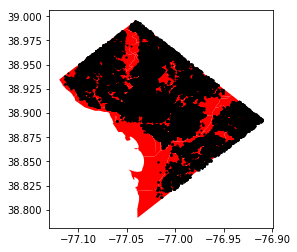

In [81]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(permits.LONGITUDE.apply(float), permits.LATITUDE.apply(float))]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(permits, crs=crs, geometry=geometry)
fig, ax = plt.subplots()
census.plot(ax=ax, color='red')
points.plot(ax=ax, color='black', marker='.', markersize=5)
ax.set_aspect('equal')

In [82]:
geo_constr = gpd.sjoin(census, points, how='left', op='intersects')
geo_constr.head()

,OBJECTID_left,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,OWNERNAME,CONTRACTORNAME,WORKDETAIL,READYFORREVIEWDATE,APPLICANTCOMPANYNAME,LATITUDE,LONGITUDE,effective_date,expire_date,endmonth
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,Greg Calderon,Gregory Calderon,Up to 3 Utility Test Holes to identify the dep...,2016-10-25T07:33:37.000Z,NaN,38.960390,-77.085981,2016-12-07,2017-02-07,2017.02
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,Lightower Lightower,LIGHTOWER LIGHTOWER,Excavate to install (2) -3' x 2' x 3' Lightowe...,2015-07-02T15:20:55.000Z,NaN,38.960464,-77.086147,2015-09-08,2015-11-06,2015.11
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,DISTRICT DEPARTMENT OF TRANSPORTATION,NaN,The Tenlytown Historical Society will clean th...,2012-10-09T16:11:46.000Z,NaN,38.960782,-77.085733,2012-10-15,2012-11-06,2012.11
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,DCWater/OPS,NaN,Repair sewer main in sidewalk.,2015-01-26T08:44:22.000Z,DCWater/OPS,38.960782,-77.085733,2015-01-26,2015-03-26,2015.03
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,Potomac Electric Power Company,NaN,WR#3486881 CUT#40139-REPLACE MANHOLE FRAME AND...,2015-08-19T15:24:41.000Z,Potomac Electric Power Company,38.960782,-77.085733,2015-08-19,2015-10-01,2015.10


In [83]:
geo_constr.geometry.head()

0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
0    POLYGON ((-77.07862731061486 38.94604079377298...
Name: geometry, dtype: object

In [110]:
Contruct2HouseRatio = pd.DataFrame(geo_constr.TRACT.value_counts()*100000/geo_constr.H0010002.sum())
Contruct2HouseRatio.columns = ['Contruct2HouseRatio']
print(Contruct2HouseRatio)

        Contruct2HouseRatio
010700             1.491650
010600             1.442772
005800             1.057858
000100             0.950502
001001             0.944392
007200             0.929554
004400             0.925190
011100             0.865838
000801             0.816087
000901             0.757608
010100             0.740152
003200             0.740152
010200             0.688655
004801             0.679927
000202             0.652870
004600             0.651997
005500             0.643269
002502             0.638905
010800             0.617957
001100             0.612720
008803             0.597009
002900             0.585663
008802             0.584790
009301             0.581298
003301             0.571697
002400             0.566461
001500             0.562096
009400             0.542022
003800             0.542022
000600             0.540276
...                     ...
007409             0.157108
009904             0.152744
009906             0.150998
007709             0

In [128]:
tracts_housepermits = census.merge(Contruct2HouseRatio, how="left", left_on='TRACT', right_index=True)
tracts_housepermits = tracts_housepermits.dropna(subset=['Contruct2HouseRatio'])
tracts_housepermits.head()

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,ACRES,SQ_MILES,Shape_Length,Shape_Area,FAGI_TOTAL_2010,FAGI_MEDIAN_2010,FAGI_TOTAL_2013,FAGI_MEDIAN_2013,geometry,Contruct2HouseRatio
index_left,,,,,,,,,,,,,,,,,,,,,
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,606.401784,0.947503,6507.906513,2.454021e+06,441410751.0,114136.5,445020421.0,105423.5,POLYGON ((-77.07862731061486 38.94604079377298...,0.944392
1,2,001002,11001001002,3442,3329,2788,185,7,311,0,...,219.834053,0.343491,3952.278513,8.896369e+05,119559942.0,74658.0,134639759.0,76705.0,POLYGON ((-77.07241230806461 38.93361179147915...,0.198130
2,3,004001,11001004001,3745,3623,3237,139,5,162,8,...,68.162548,0.106504,2361.335362,2.758440e+05,203836328.0,72807.0,230295472.0,77629.0,POLYGON ((-77.04659929925825 38.92324478991338...,0.206858
3,4,004002,11001004002,2797,2720,2232,226,4,181,1,...,48.451481,0.075705,2132.734912,1.960762e+05,132421749.0,60460.5,170535365.0,65155.0,"POLYGON ((-77.04609029867974 38.9144417882433,...",0.199876
4,5,004100,11001004100,2708,2646,2261,115,9,181,3,...,201.868555,0.315420,3872.498178,8.169331e+05,403203164.0,87019.0,217573711.0,81283.5,POLYGON ((-77.04995330062248 38.92084978921181...,0.453867


In [88]:
Construct = pd.DataFrame(geo_constr.TRACT.value_counts())
Construct.columns = ['Construct']
print(Construct)

        Construct
010700       1709
010600       1653
005800       1212
000100       1089
001001       1082
007200       1065
004400       1060
011100        992
000801        935
000901        868
010100        848
003200        848
010200        789
004801        779
000202        748
004600        747
005500        737
002502        732
010800        708
001100        702
008803        684
002900        671
008802        670
009301        666
003301        655
002400        649
001500        644
009400        621
003800        621
000600        619
...           ...
007409        180
009904        175
009906        173
007709        172
002001        158
011000        157
002202        153
009507        148
009804        146
007404        142
009802        130
007408        129
009801        127
010900        127
007708        125
009903        125
007406        119
007605        119
009000        117
009811        112
009810        102
001803        101
009700         97
009907    

In [126]:
tracts_construction = census.merge(Construct, how="left", left_on='TRACT', right_index=True)
tracts_construction.head()

,OBJECTID,TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,ACRES,SQ_MILES,Shape_Length,Shape_Area,FAGI_TOTAL_2010,FAGI_MEDIAN_2010,FAGI_TOTAL_2013,FAGI_MEDIAN_2013,geometry,Construct
index_left,,,,,,,,,,,,,,,,,,,,,
0,1,001001,11001001001,7436,7168,6342,298,17,432,2,...,606.401784,0.947503,6507.906513,2.454021e+06,441410751.0,114136.5,445020421.0,105423.5,POLYGON ((-77.07862731061486 38.94604079377298...,1082
1,2,001002,11001001002,3442,3329,2788,185,7,311,0,...,219.834053,0.343491,3952.278513,8.896369e+05,119559942.0,74658.0,134639759.0,76705.0,POLYGON ((-77.07241230806461 38.93361179147915...,227
2,3,004001,11001004001,3745,3623,3237,139,5,162,8,...,68.162548,0.106504,2361.335362,2.758440e+05,203836328.0,72807.0,230295472.0,77629.0,POLYGON ((-77.04659929925825 38.92324478991338...,237
3,4,004002,11001004002,2797,2720,2232,226,4,181,1,...,48.451481,0.075705,2132.734912,1.960762e+05,132421749.0,60460.5,170535365.0,65155.0,"POLYGON ((-77.04609029867974 38.9144417882433,...",229
4,5,004100,11001004100,2708,2646,2261,115,9,181,3,...,201.868555,0.315420,3872.498178,8.169331e+05,403203164.0,87019.0,217573711.0,81283.5,POLYGON ((-77.04995330062248 38.92084978921181...,520


In [129]:
tracts_construction.corr()['Construct'].sort_values()

P0020006           -0.261472
P0010004           -0.259658
P0040006           -0.227277
P0030004           -0.224933
OBJECTID           -0.037660
P0010008            0.024537
OP000001            0.027752
OP00006             0.030719
P0030008            0.032247
OP00005             0.035081
P0010007            0.043464
OP00009             0.044671
P0020009            0.045459
OP000002            0.046621
P0020007            0.051757
OP000013            0.059832
P0030007            0.061382
P0010005            0.071961
P0040009            0.078678
P0040007            0.080429
OP000014            0.095446
OP00010             0.099620
OP00008             0.102800
P0020002            0.103117
OP000004            0.103815
P0030005            0.105039
Shape_Length        0.113443
ACRES               0.118205
Shape_Area          0.118205
SQ_MILES            0.118205
P0040002            0.121239
OP00012             0.130993
OP000016            0.179779
H0010003            0.196766
H0010002      